In [2]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   

#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

In [3]:
pd.set_option('display.max_colwidth', 4000)

In [67]:
#importing the dataset
train=pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip")
test=pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip")

In [68]:
#take a peak
train.tail(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159561,ffd2e85b07b3c7e4,"""\nNo he did not, read it again (I would have thought everyone here could recite it by heart by now) it says """"Are we truly to believe the arbcom are so thankful for that, and Jimbo was ever so taken with her"""". The arbcom having read the evidence are now voting to thank her - so it is a very valid question. Kelly always implied she was a friend of Jimbo's. Good for her, that must be very pleasant for them both. However, I can't imagine Jimbo was particularly impressed by that blog either. If you actually read the blog, not just what was pasted to wiki, there is a lot of information on her views in other areas. I was also commenting on those. I don't imagine Jimbo is much impressed by me or many others concerned with whole rotten case either, but it's all a bit late for those concerns now. Now this is actually Bishonen's page, so my further views will be posted on my own page, if I decide to post them that is, because I too am heartily sick of this whole case, it is just a pity reference to that blog was ever permitted as evidence, especially if people do not in fact want to discuss it or here concerned parties views on it. """,0,0,0,0,0,0
159562,ffd72e9766c09c97,"""\n Auto guides and the motoring press are not good sources for an encyclopedia article about """"luxury vehicle"""". This is because automakers feed the press a lot of BS (Boastful Superlatives) who then work hard to write articles adding even more BS to describe their products. The press earns credits from the hands that feed them. Add to this the fact that potential and actual purchasers of luxury vehicles have an insatiable appetite for this type of BS. Classifying a particular vehicle as """"luxury"""" is also designed to easily make it superior to other vehicles even if the differences are superficial. Using self-serving BS in marketing claims is a very, very old invention that helps sell products, as well as fuel the fan base with """"bragging"""" rights to which vehicles are """"luxury"""". On the other hand, it is more difficult for most marketers to be humble and genuine. That is why an encyclopedia article has to avoid falling into the trap of using traditional marketing superlatives and hyperbole. — """,0,0,0,0,0,0
159563,ffe029a7c79dc7fe,"""\nplease identify what part of BLP applies because BLP clearly states that we must follow NPOV which says that we must present content in relation to the manner the subject is covered in reliable academic sources. In this case there has not been any substantial mainstream academic sources provided which is not critical of views and claims that Chopra makes. TRPoD aka The Red Pen of Doom \n""",0,0,0,0,0,0
159564,ffe897e7f7182c90,Catalan independentism is the social movement involving more people in Catalonia. Votes in the referendum at Barcelona were more than the ones received by political parties that are leading the council (PSC and CIU) . 20% of votes of the total census voting in favour of a referendum that is forbidden by spanish courts and that has no legal effects is highly relevant.,0,0,0,0,0,0
159565,ffe8b9316245be30,"The numbers in parentheses are the additional decimal points which have been measured but lie outside the accuracy of the measurement process. This means the values in the parentheses eg (15) could be used for the purpose of calculation, but any value that results from such a calculation would not be more accurate than the number of significant figures if those in parentheses were not considered. In other words, the values in parentheses are there to help avoid rounding errors if you’re trying to work to the limit of accuracy of the gas constant. I agree that this is not commonly known, and only confuses the issue. I would recommend removing it.",0,0,0,0,0,0
159566,ffe987279560d7ff,""":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources,

In [69]:
nrow_train=train.shape[0]
nrow_test=test.shape[0]
sum=nrow_train+nrow_test
print("       : train : test")
print("rows   :",nrow_train,":",nrow_test)
print("perc   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

       : train : test
rows   : 159571 : 153164
perc   : 51    : 49


There is a 51:49 train: test split and the test set.

Let's take a look at the class imbalance in the train set.

### Class Imbalance:

In [70]:
x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


In [71]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with "unknown"


In [72]:
temp_df=train.iloc[:,2:-1]
len(temp_df[~train.clean])

16225

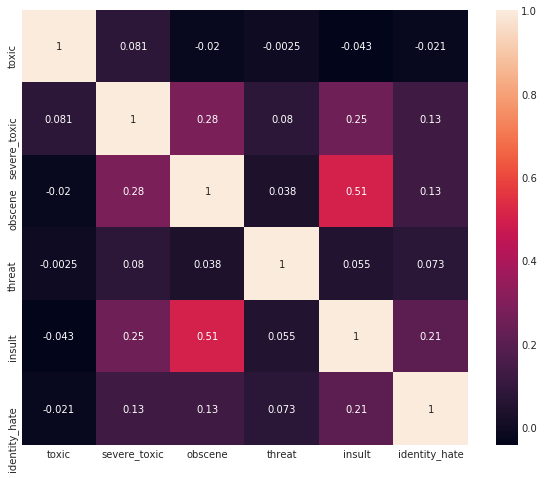

In [73]:
temp_df=train.iloc[:,2:-1]
# filter temp by removing clean comments
temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

The above plot indicates a pattern of co-occurance but Pandas's default Corr function which uses Pearson correlation does not apply here, since the variables invovled are Categorical (binary) variables.

So, to find a pattern between two categorical variables we can use other tools like 
* Confusion matrix/Crosstab
* Cramer's V Statistic
    * Cramer's V stat is an extension of the chi-square test where the extent/strength of association is also measured

In [74]:
# https://pandas.pydata.org/pandas-docs/stable/style.html
def highlight_min(data, color='yellow'):
    '''
    highlight the minimum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [75]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a 
# look at toxic with other tags
main_col="toxic"
corr_mats=[]
other_cols = [i for i in temp_df.columns if i!=main_col]
for other_col in other_cols:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

#cell highlighting
out = out.style.apply(highlight_min,axis=0)
out

In [76]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a 
# look at toxic with other tags
main_col="insult"
corr_mats=[]
other_cols = [i for i in temp_df.columns if i!=main_col]
for other_col in other_cols:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=other_cols)

#cell highlighting
out = out.style.apply(highlight_min,axis=0)
out

The above table represents the Crosstab/ consufion matix of Toxic comments with the other classes. 

Some interesting observations:

* A Severe toxic comment is always toxic
* Other classes seem to be a subset of toxic barring a few exceptions



In [77]:
#https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix/39266194
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [78]:
#Checking for Toxic and Severe toxic for now
import pandas as pd
col1="toxic"
col2="severe_toxic"
confusion_matrix = pd.crosstab(temp_df[col1], temp_df[col2])
print("Confusion matrix between toxic and severe toxic:")
print(confusion_matrix)
new_corr=cramers_corrected_stat(confusion_matrix)
print("The correlation between Toxic and Severe toxic using Cramer's stat=",new_corr)

Confusion matrix between toxic and severe toxic:
severe_toxic      0     1
toxic                    
0               931     0
1             13699  1595
The correlation between Toxic and Severe toxic using Cramer's stat= 0.08064141470322429


In [79]:
#Checking for obscene and insult for now
import pandas as pd
col1="obscene"
col2="insult"
confusion_matrix = pd.crosstab(temp_df[col1], temp_df[col2])
print("Confusion matrix between obscene and insult:")
print(confusion_matrix)
new_corr=cramers_corrected_stat(confusion_matrix)
print("The correlation between Obscene and Insult using Cramer's stat=",new_corr)

Confusion matrix between obscene and insult:
insult      0     1
obscene            
0        6054  1722
1        2294  6155
The correlation between Obscene and Insult using Cramer's stat= 0.5066465421709249



## Example Comments:

In [80]:
print("toxic:")
print(train[train.severe_toxic==1].iloc[3,1])
#print(train[train.severe_toxic==1].iloc[5,1])

toxic:
Hi 

Im a fucking bitch.

50.180.208.181


In [81]:
print("severe_toxic:")
print(train[train.severe_toxic==1].iloc[1,1])
#print(train[train.severe_toxic==1].iloc[4,1])

severe_toxic:
Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!


In [82]:
print("Threat:")
print(train[train.threat==1].iloc[7,1])
#print(train[train.threat==1].iloc[2,1])

Threat:
Demonte Morton 

U bastard stop deletin' my shit u white trash cracker muthafucker. Fuck u u racist bitch. I hope u die.


In [83]:
print("Obscene:")
print(train[train.obscene==1].iloc[1,1])
#print(train[train.obscene==1].iloc[2,1])

Obscene:
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!


In [84]:
print("identity_hate:")
print(train[train.identity_hate==1].iloc[4,1])
#print(train[train.identity_hate==1].iloc[4,1])

identity_hate:
u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie


In [85]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)

In [86]:
len(df)

312735

In [87]:
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
# df["count_words_upper_perc"] = df["count_words_upper"].apply(lambda x: x/len(df["comment_text"].split()))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [88]:
df_with_feats = train.copy()
df_with_feats["count_words_upper_perc"] = df["comment_text"].apply(lambda x: (len([w for w in str(x).split() if w.isupper()])/(len(str(x).split()))) if len(str(x).split())!=0 else 0)

In [89]:
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'clean'],
      dtype='object')

In [90]:
df_with_feats["count_words_upper_perc"] = df_with_feats["count_words_upper_perc"].apply(lambda x: x*100)

In [92]:
sentiment_classes = train.columns[2:-2]
cap_perc = []
for i in sentiment_classes:
    sdf = df_with_feats[df_with_feats[i]==1]
    cap_perc.append(list(sdf["count_words_upper_perc"].values))

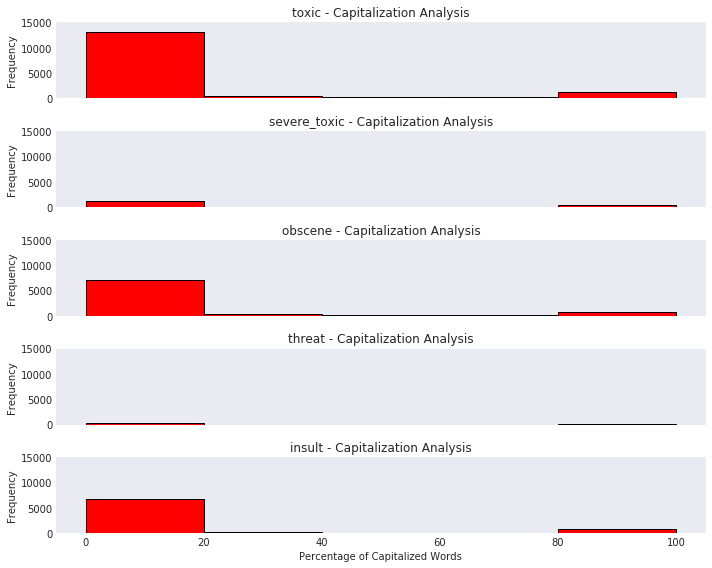

In [93]:
# Plotting the histogram for each sentiment class
fig, axs = plt.subplots(len(sentiment_classes), 1, figsize=(10, 8), sharex=True)

for i, sentiment_class in enumerate(sentiment_classes):
    axs[i].hist(cap_perc[i], bins=range(0, 101, 20), color='red', edgecolor='black')
    axs[i].set_title(f'{sentiment_class} - Capitalization Analysis')
    axs[i].set_ylabel('Frequency')
    axs[i].set_yticks(range(0, 15001, 5000))

# Adding labels and title
plt.xlabel('Percentage of Capitalized Words')
plt.tight_layout()
plt.xticks(range(0, 101, 20))
plt.show()

In [94]:
# Sample data
sentiment_classes = train.columns[2:-2]  # Replace with your actual classes
# capitalization_percentages = np.random.randint(0, 101, (len(sentiment_classes), 100))  # Replace with your actual data
cap_perc = []
for i in sentiment_classes:
    sdf = df_with_feats[df_with_feats[i]==1]
    cap_perc.append(list(sdf["count_words_upper_perc"].values))

In [95]:
#derived features
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#derived features
#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

In [96]:
#serperate train and test features
train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]
#join the tags
train_tags=train.iloc[:,2:]
train_feats=pd.concat([train_feats,train_tags],axis=1)

In [97]:
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0,True
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0,True
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0,True
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0,True
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0,True
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the tools well. · talk """,0,0,0,0,0,0,True
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,False
7,00031b1e95af7921,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0,0,0,0,0,0,True
8,00037261f536c51d,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0,0,0,0,0,0,True
9,00040093b2687caa,alignment on this subject and which are contrary to those of DuLithgow,0,0,0,0,0,0,True


In [99]:
train_feats['count_unique_word'].loc[train_feats['count_unique_word']>200] = 200
#prep for split violin plots

#For the desired plots , the data must be in long format
temp_df = pd.melt(train_feats, value_vars=['count_word', 'count_unique_word'], id_vars='clean')

#spammers - comments with less than 40% unique words
spammers=train_feats[train_feats['word_unique_percent']<30]

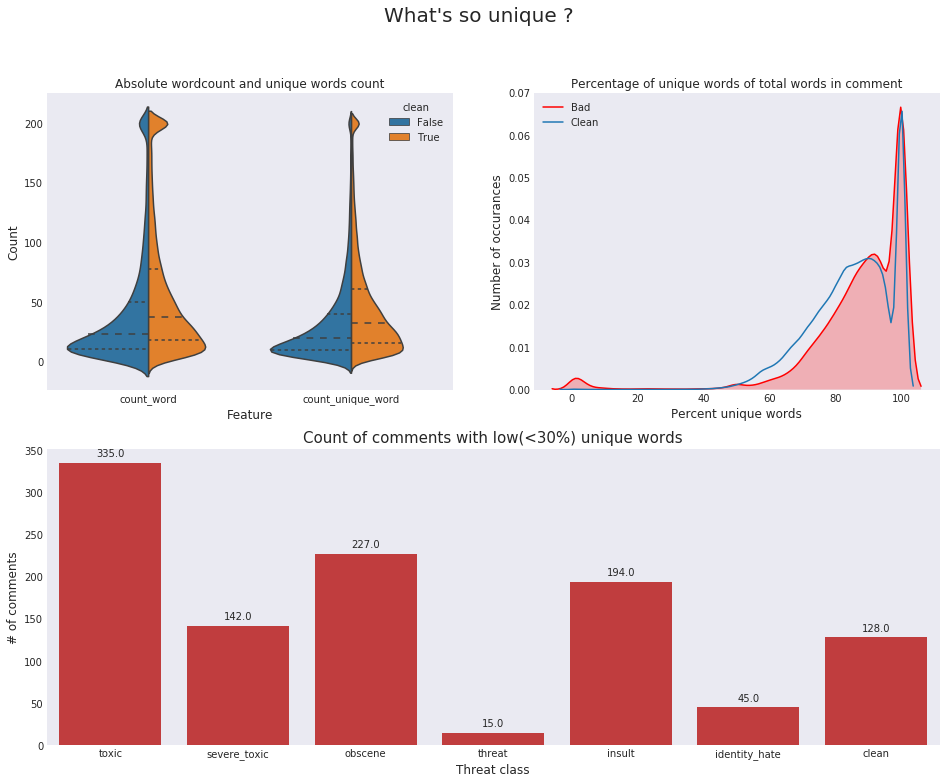

In [100]:
plt.figure(figsize=(16,12))
plt.suptitle("What's so unique ?",fontsize=20)
gridspec.GridSpec(2,2)
plt.subplot2grid((2,2),(0,0))
sns.violinplot(x='variable', y='value', hue='clean', data=temp_df,split=True,inner='quartile')
plt.title("Absolute wordcount and unique words count")
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot2grid((2,2),(0,1))
plt.title("Percentage of unique words of total words in comment")
ax=sns.kdeplot(train_feats[train_feats.clean == 0].word_unique_percent, label="Bad",shade=True,color='r')
ax=sns.kdeplot(train_feats[train_feats.clean == 1].word_unique_percent, label="Clean")
plt.legend()
plt.ylabel('Number of occurances', fontsize=12)
plt.xlabel('Percent unique words', fontsize=12)

x=spammers.iloc[:,-7:].sum()
plt.subplot2grid((2,2),(1,0),colspan=2)
plt.title("Count of comments with low(<30%) unique words",fontsize=15)
ax=sns.barplot(x=x.index, y=x.values,color=color[3])

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.xlabel('Threat class', fontsize=12)
plt.ylabel('# of comments', fontsize=12)
plt.show()

### Word count VS unique word count:
There are noticeable shifts in the mean of both word count and unique word count across clean and toxic comments.
   * Chart desc: The first chart is a split violin chart. It is a variation of the traditional box chart/violin chart which allows us to split the violin in the middle based on a categorical variable.
   
### Unique word count percent:
There is a bulge near the 0-10% mark which indicates a large number of toxic comments which contain very little variety of words.
   * Chart desc: The second chart is an overlay of two kernel density estimation plots of percentage of unique words out of all the words in the comment, done for both clean and toxic comments

Even though the number of clean comments dominates the dataset(~90%), there are only 75 clean comments that are spam, which makes it a powerful indicator of a toxic comment.
# Spammers are more toxic!
No surprises here. Let's take a look at some clean and toxic spam messages

In [43]:
print("Clean Spam example:")
print(spammers[spammers.clean==1].comment_text.iloc[1])
print("Toxic Spam example:")
print(spammers[spammers.toxic==1].comment_text.iloc[2])

Clean Spam example:
Towns and Villages in Ark-La-Tex]]
 Cities, boroughs and towns in the Republic of Ireland
 Cities, boroughs, and townships along the Susquehanna River
 Cities, towns and villages in Alborz Province
 Cities, towns and villages in Ardabil Province
 Cities, towns and villages in Bhutan
 Cities, towns and villages in Bushehr Province
 Cities, towns and villages in Chaharmahal and Bakhtiari Province
 Cities, towns and villages in Cyprus
 Cities, towns and villages in Dutch Limburg
 Cities, towns and villages in East Azerbaijan Province
 Cities, towns and villages in East Timor
 Cities, towns and villages in Fars Province
 Cities, towns and villages in Flevoland
 Cities, towns and villages in Friesland
 Cities, towns and villages in Gelderland
 Cities, towns and villages in Gilan Province
 Cities, towns and villages in Golestan Province
 Cities, towns and villages in Groningen
 Cities, towns and villages in Hamadan Province
 Cities, towns and villages in Hormozgan Provinc